In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import os
import time
import numpy as np
import matplotlib.pyplot as plt

### Parameters

In [2]:
params = {
    "b_size": 32, # batch size 
    "num_classes": 10, # number of classes (0,1,2,...,9)
    "epochs": 5, # total number of epochs
    "lr": 1e-4, # learning rate
    "img_size": (28,28), # image shape
    "in_channel": 1, #input channel
    "ADD_SPARSITY":True, # for sparsity autoencoder
    "BETA": 0.001,
    "RHO": 0.05,
}

### Dataloader

In [3]:
dataloader_train = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion_mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=params["b_size"],
    shuffle=True,
)


dataloader_test = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion_mnist",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=params["b_size"],
    shuffle=True,
)

### Sample visualization

In [4]:
sample_batch = next(iter(dataloader_test))

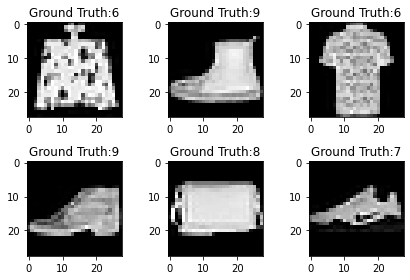

In [5]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(torch.squeeze(sample_batch[0][i]), cmap='gray', interpolation=None) # use cmap='gray' for the gray images
    plt.title(f"Ground Truth:{sample_batch[1][i]}")
    

#### Some utils function for: device selection, make directory for compressed image, and function to save images

In [6]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [7]:
def make_dir():
    image_dir = "./output/images"
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
make_dir()

In [8]:
# for saving the reconstructed images
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img,name)

## Create Sparse variational Encoder network

In [9]:
class SAENet(nn.Module): # sparse autoencoders
    def __init__(self,):
        super(SAENet, self).__init__()
        
        # Encoder 
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        
        # Decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
    def forward(self, img):
        # Encoder
        img = F.relu(self.enc1(img))
        img = F.relu(self.enc2(img))
        img = F.relu(self.enc3(img))
        img = F.relu(self.enc4(img))
        img = F.relu(self.enc5(img))
        
        # Decoder 
        img = F.relu(self.dec1(img))
        img = F.relu(self.dec2(img))
        img = F.relu(self.dec3(img))
        img = F.relu(self.dec4(img))
        img = F.relu(self.dec5(img))
        
        return img

In [10]:
model = SAENet().to(get_device())

In [11]:
model_children = list(model.children())
model_children

[Linear(in_features=784, out_features=256, bias=True),
 Linear(in_features=256, out_features=128, bias=True),
 Linear(in_features=128, out_features=64, bias=True),
 Linear(in_features=64, out_features=32, bias=True),
 Linear(in_features=32, out_features=16, bias=True),
 Linear(in_features=16, out_features=32, bias=True),
 Linear(in_features=32, out_features=64, bias=True),
 Linear(in_features=64, out_features=128, bias=True),
 Linear(in_features=128, out_features=256, bias=True),
 Linear(in_features=256, out_features=784, bias=True)]

### Loss function and optimizer selection

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

### Sparsity and KL divergence

In [13]:
def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(torch.sigmoid(rho_hat), 1) # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(rho_hat)).to(get_device())
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))

In [14]:
# define the sparse loss function
def sparse_loss(rho, images):
    values = images
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += kl_divergence(rho, values)
    return loss

### Training function

In [15]:
def fit(model, dataloader, epoch):
    print("Training.....")
    model.train()
    running_loss = 0.0 
    counter = 0
    for i,data in enumerate(dataloader):
#     for i, data in tqdm(enumerate(dataloader), total=int(len(dataloader_train)/dataloader.batch_size)):
        counter += 1 
        img,_ = data 
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs = model(img)
        mse_loss = criterion(outputs, img)
        if params["ADD_SPARSITY"]:
            sparsity = sparse_loss(params['RHO'], img)
            loss = mse_loss+params["BETA"]*sparsity
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        
    epoch_loss = running_loss/counter
    print(f"Training Loss: {epoch_loss:.3f}")
    outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
    save_image(outputs, f"./output/images/reconstruction{epoch}.png")
    
    return epoch_loss

### Validation function

In [16]:
def validate(model, dataloader, epoch):
    print("Validating.....")
    model.eval()
    running_loss = 0.0 
    counter = 0 
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            img, _ = data 
            img = img.to(get_device())
            img = img.view(img.size(0), -1)
            outputs = model(img)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    epoch_loss = running_loss/counter
    print(f"val loss: {epoch_loss:.3f}")
    # Save Reconstructed Image
    outputs = outputs.view(outputs.size(0),1,28,28).cpu().data
    save_image(outputs, f"./output/images/reconstuction_val{epoch}.png")
    
    return epoch_loss

### Executing Training and Validation Function

In [17]:
train_loss = []
val_loss = []
start = time.time()
for epoch in range(params['epochs']):
    print(f"({epoch+1}/{params['epochs']})")
    train_epoch_loss = fit(model, dataloader_train, epoch)
    val_epoch_loss = validate(model, dataloader_test, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

(1/5)
Training.....
Training Loss: 0.096
Validating.....
val loss: 0.061
(2/5)
Training.....
Training Loss: 0.060
Validating.....
val loss: 0.041
(3/5)
Training.....
Training Loss: 0.048
Validating.....
val loss: 0.038
(4/5)
Training.....
Training Loss: 0.044
Validating.....
val loss: 0.036
(5/5)
Training.....
Training Loss: 0.043
Validating.....
val loss: 0.035
3.948 minutes


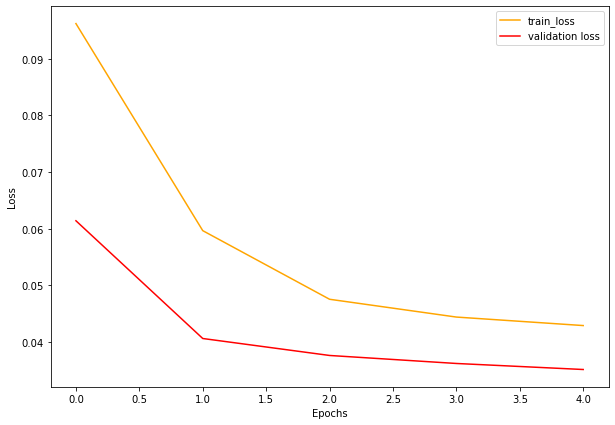

In [18]:
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='orange', label='train_loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./output/loss.png")
plt.show()

### Save the trained Model

In [19]:
torch.save(model.state_dict(), f"./output/sparse_autoEncoder.pth")